<a href="https://colab.research.google.com/github/gilbert-umuzi/donor_eda/blob/main/donor_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis of Nonprofit Donor Data

This notebook presents an exploratory data analysis (EDA) of donor data for a nonprofit organization. The analysis aims to provide insights into donor behavior, segmentation, and giving patterns to inform fundraising strategies.

Key areas of analysis include:
1. Data cleaning and preprocessing
2. Donor segmentation
3. Temporal analysis of donations
4. Donor retention analysis
5. Geographical analysis
6. Lead source analysis
7. Job sector analysis

The dataset contains information on donor characteristics, donation history, and various segmentation attributes.

In [1]:
# Install packages
!pip install lifelines # for Kaplan-Meier survival analysis
!pip install squarify

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from lifelines import KaplanMeierFitter
import calendar
import squarify

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn')

## Data Cleaning and Preprocessing

The initial data cleaning steps include:

1. Handling missing values in donation columns
2. Imputing missing dates for first donations
3. Addressing negative donation values
4. Calculating data availability and identifying columns with sufficient data

Key observations:
- Most donation-related columns have complete data after cleaning
- Demographic and segmentation columns (e.g., Job sector, Management Status) have significant missing data
- Country and State/Province information is available for a majority of donors

This cleaned dataset provides a solid foundation for further analysis, with a focus on donation patterns and basic donor attributes.

In [3]:
# 1. Data Loading and Cleaning

# List of donation columns
total_donation_columns = ['Total donations in 2017', 'Total donations in 2018', 'Total donations in 2019',
                    'Total donations in 2020', 'Total donations in 2021', 'Total donations in 2022',
                    'Total donations in 2023']

donation_columns = [f'Total donations in {year}' for year in range(2017, 2024)] + [
    'Amount of first donation',
    'Amount of last donation',
    'Highest amount donated in one year',
    'Total Gifts'
]

provided_segments = ['Management Status','Lead source','Job sector','Allocations Supported','Has a planned gift?','Approximate Birth Year']

def load_data(file_path):
    """Load the donor data from a CSV file."""
    return pd.read_csv(file_path)

def clean_data(df):
    """Clean and preprocess the donor data."""
    # Rename columns
    df = df.rename(columns={'Totan donations in 2022': 'Total donations in 2022',
                            'Was their first donation an automatically-recurring transaction?': 'recurring'})

    # Convert dollar columns to numerical (float)
    dollar_columns = ['Total donations in 2017', 'Total donations in 2018',
                      'Total donations in 2019', 'Total donations in 2020',
                      'Total donations in 2021', 'Total donations in 2022',
                      'Total donations in 2023', 'Amount of first donation',
                      'Amount of last donation', 'Highest amount donated in one year', 'Estimated giving capacity']

    def dollar_to_float(dollar_str):
        if isinstance(dollar_str, str):
            return round(float(dollar_str.replace('$', '').replace(',', '')), 2)
        return dollar_str

    for column in dollar_columns:
        df[column] = df[column].apply(dollar_to_float)

    # Convert date columns to datetime
    date_columns = ['Date of first donation', 'Date of last donation']
    df[date_columns] = df[date_columns].apply(pd.to_datetime, errors='coerce')

    # Create 'Total Gifts' column
    donation_columns = [f'Total donations in {year}' for year in range(2017, 2024)]
    df['Total Gifts'] = df[donation_columns].sum(axis=1)

    return df

# Load and clean the data
df = load_data('/content/nonprofit_donor_data.csv')
df = clean_data(df)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37964 entries, 0 to 37963
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Unique donor ID                     37964 non-null  object        
 1   Total donations in 2017             37963 non-null  float64       
 2   Total donations in 2018             37963 non-null  float64       
 3   Total donations in 2019             37963 non-null  float64       
 4   Total donations in 2020             37964 non-null  float64       
 5   Total donations in 2021             37964 non-null  float64       
 6   Total donations in 2022             37942 non-null  float64       
 7   Total donations in 2023             35908 non-null  float64       
 8   Amount of first donation            37961 non-null  float64       
 9   Date of first donation              37890 non-null  datetime64[ns]
 10  recurring             

,Unique donor ID,Total donations in 2017,Total donations in 2018,Total donations in 2019,Total donations in 2020,Total donations in 2021,Total donations in 2022,Total donations in 2023,Amount of first donation,Date of first donation,...,Lead source,State/Province,Country,Approximate Birth Year,Management Status,Estimated giving capacity,Job sector,Allocations Supported,Total Gifts,Has a planned gift?
0,0031Y00004il5RfQAI,900.0,1200.0,400.0,0.00,0.0,0.0,0.0,75.00,2017-05-21,...,NaN,NaN,SE,NaN,NaN,0.0,NaN,"Top Charities Fund,GiveDirectly",2500.00,0
1,0031Y00004il9ieQAA,990.0,660.0,0.0,0.00,0.0,0.0,0.0,100.00,2017-05-23,...,NaN,Pennsylvania,United States,1973.0,NaN,19138.0,NaN,"Top Charities Fund,Unrestricted",1650.00,0
2,0031Y00004il9S7QAI,258.0,1100.0,1079.0,1146.00,0.0,0.0,0.0,105.00,2017-05-23,...,NaN,Munster,IE,NaN,NaN,0.0,NaN,"Top Charities Fund,Unrestricted",3583.00,0
3,0031Y00004ilAPQQA2,180.0,180.0,240.0,60.00,160.0,240.0,80.0,20.00,2017-05-23,...,Podcast,???,JP,NaN,NaN,0.0,NaN,Top Charities Fund,1140.00,0
4,0031Y00004ilBxMQAU,228.0,0.0,354.0,251.85,0.0,0.0,0.0,76.25,2016-08-12,...,NaN,NaN,Australia,NaN,NaN,NaN,NaN,GiveDirectly,833.85,0


In [4]:
# Missing values
def assess_data_quality(df):
    print("Missing values:\n", df.isnull().sum())
    print("\nUnique values in categorical columns:")
    for col in df.select_dtypes(include=['object']).columns:
        print(f"{col}: {df[col].nunique()}")

assess_data_quality(df)

Missing values:
 Unique donor ID                           0
Total donations in 2017                   1
Total donations in 2018                   1
Total donations in 2019                   1
Total donations in 2020                   0
Total donations in 2021                   0
Total donations in 2022                  22
Total donations in 2023                2056
Amount of first donation                  3
Date of first donation                   74
recurring                                 0
Amount of last donation                   0
Date of last donation                     1
Year with the most dollars donated        0
Highest amount donated in one year        0
Lead source                           17160
State/Province                        11275
Country                                6414
Approximate Birth Year                29505
Management Status                     32564
Estimated giving capacity             21102
Job sector                            36582
Allocations Sup

Let's categorize the columns based on the percentage of missing values:

- **Low missing values (0-5%):** Total donations in 2017, Total donations in 2018, Total donations in 2019, Amount of first donation, Date of first donation, Date of last donation, Allocations Supported.
- **Moderate missing values (5-30%):** Total donations in 2022, Lead source, State/Province, Country.
- **High missing values (30-100%):** Approximate Birth Year, Management Status, Estimated giving capacity, Job sector.

In [5]:
df[df['Total donations in 2023'].isnull()==True].sort_values('Date of last donation', ascending=False)

,Unique donor ID,Total donations in 2017,Total donations in 2018,Total donations in 2019,Total donations in 2020,Total donations in 2021,Total donations in 2022,Total donations in 2023,Amount of first donation,Date of first donation,...,Lead source,State/Province,Country,Approximate Birth Year,Management Status,Estimated giving capacity,Job sector,Allocations Supported,Total Gifts,Has a planned gift?
18152,0035d00006kMy23AAC,0.0,0.0,0.0,0.00,0.0,516347.14,NaN,327712.17,NaT,...,Effective Altruism,NaN,Norway,NaN,NaN,NaN,NaN,NaN,516347.14,0
19201,0035d00006OxHamAAF,0.0,0.0,0.0,1951.26,0.0,0.00,NaN,1951.26,2020-12-31,...,NaN,NaN,Canada,NaN,NaN,NaN,NaN,Against Malaria Foundation,1951.26,0
5290,0031Y00005QjUlsQAF,0.0,0.0,0.0,8351.37,0.0,0.00,NaN,8351.37,2020-12-31,...,NaN,NaN,Canada,NaN,NaN,NaN,NaN,GiveDirectly,8351.37,0
19256,0035d00006OxICyAAN,0.0,0.0,0.0,2105.33,0.0,0.00,NaN,2105.33,2020-12-31,...,NaN,NaN,Canada,NaN,NaN,NaN,NaN,GiveDirectly,2105.33,0
19368,0035d00006OxJL7AAN,0.0,0.0,0.0,1365.88,0.0,0.00,NaN,390.25,2020-12-31,...,NaN,NaN,Canada,NaN,NaN,NaN,NaN,Evidence Action (Deworm the World),1365.88,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28001,003i000000BPPgSAAX,0.0,0.0,0.0,0.00,0.0,0.00,NaN,2000.00,2009-11-15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stop TB Partnership,0.00,0
27680,003i000000BPOxPAAX,0.0,0.0,0.0,0.00,0.0,0.00,NaN,1300.00,2009-11-09,...,NaN,VIC,Australia,NaN,NaN,0.0,NaN,Unrestricted,0.00,0
26823,003i000000BPNhSAAX,0.0,0.0,0.0,0.00,0.0,0.00,NaN,1650.00,2008-09-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Knowledge is Power Program,0.00,0
26822,003i000000BPNhRAAX,0.0,0.0,0.0,0.00,0.0,0.00,NaN,1330.00,2008-09-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Partners in Health,0.00,0


It appears that the missing data in 'Total donations in {year}' columns are null values before the first donation and after the last donation. We can replace these values with 0.

In [6]:
# Iterate over each donation column
for column in total_donation_columns:
    year = int(column.split()[-1])

    # Replace NaNs for years after 'Date of last donation'
    df.loc[(df[column].isnull()) & (df['Date of last donation'].dt.year < year), column] = 0

    # Replace NaNs for years before 'Date of first donation'
    df.loc[(df[column].isnull()) & (df['Date of first donation'].dt.year > year), column] = 0

# Display the updated DataFrame
assess_data_quality(df)

Missing values:
 Unique donor ID                           0
Total donations in 2017                   0
Total donations in 2018                   0
Total donations in 2019                   1
Total donations in 2020                   0
Total donations in 2021                   0
Total donations in 2022                   0
Total donations in 2023                   0
Amount of first donation                  3
Date of first donation                   74
recurring                                 0
Amount of last donation                   0
Date of last donation                     1
Year with the most dollars donated        0
Highest amount donated in one year        0
Lead source                           17160
State/Province                        11275
Country                                6414
Approximate Birth Year                29505
Management Status                     32564
Estimated giving capacity             21102
Job sector                            36582
Allocations Sup

That's cleared up all of the missing values except for 'Total donations in 2019'.

In [7]:
df[df['Total donations in 2019'].isnull()==True].sort_values('Date of last donation', ascending=False)

,Unique donor ID,Total donations in 2017,Total donations in 2018,Total donations in 2019,Total donations in 2020,Total donations in 2021,Total donations in 2022,Total donations in 2023,Amount of first donation,Date of first donation,...,Lead source,State/Province,Country,Approximate Birth Year,Management Status,Estimated giving capacity,Job sector,Allocations Supported,Total Gifts,Has a planned gift?
37862,003Qi00000ApmuVIAR,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,2019-09-19,...,NaN,NaN,NaN,NaN,Mid-Level,NaN,NaN,NaN,0.0,0


Given how little data we have on this donor, ley's drop them for now, noting they are potentially a large donor we should follow up on.

In [8]:
# Drop rows where 'Total donations in 2019' is null
df = df[df['Total donations in 2019'].notnull()]
assess_data_quality(df)

Missing values:
 Unique donor ID                           0
Total donations in 2017                   0
Total donations in 2018                   0
Total donations in 2019                   0
Total donations in 2020                   0
Total donations in 2021                   0
Total donations in 2022                   0
Total donations in 2023                   0
Amount of first donation                  2
Date of first donation                   74
recurring                                 0
Amount of last donation                   0
Date of last donation                     0
Year with the most dollars donated        0
Highest amount donated in one year        0
Lead source                           17159
State/Province                        11274
Country                                6413
Approximate Birth Year                29504
Management Status                     32564
Estimated giving capacity             21101
Job sector                            36581
Allocations Sup

In [9]:
df[df['Amount of first donation'].isnull()==True]

,Unique donor ID,Total donations in 2017,Total donations in 2018,Total donations in 2019,Total donations in 2020,Total donations in 2021,Total donations in 2022,Total donations in 2023,Amount of first donation,Date of first donation,...,Lead source,State/Province,Country,Approximate Birth Year,Management Status,Estimated giving capacity,Job sector,Allocations Supported,Total Gifts,Has a planned gift?
6243,0031Y00005wOl99QAC,0.0,0.0,1098.0,0.0,0.0,0.0,0.0,NaN,NaT,...,NaN,ID,NaN,1954.0,NaN,NaN,NaN,NaN,1098.0,0
9613,0031Y000066ReUPQA0,0.0,0.0,0.0,1200.0,0.0,0.0,0.0,NaN,NaT,...,Podcast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200.0,0


'Total gifts' = 'Total donations in 2019' so we can assume Amount of first donation = 'Total donations in 2019'

In [10]:
# Manually replace 'Amount of first donation' for specific rows
df.loc[6243, 'Amount of first donation'] = df.loc[6243, 'Total donations in 2019']
df.loc[9613, 'Amount of first donation'] = df.loc[9613, 'Total donations in 2020']

# Display the rows to verify the changes
df.loc[[6243, 9613]]

,Unique donor ID,Total donations in 2017,Total donations in 2018,Total donations in 2019,Total donations in 2020,Total donations in 2021,Total donations in 2022,Total donations in 2023,Amount of first donation,Date of first donation,...,Lead source,State/Province,Country,Approximate Birth Year,Management Status,Estimated giving capacity,Job sector,Allocations Supported,Total Gifts,Has a planned gift?
6243,0031Y00005wOl99QAC,0.0,0.0,1098.0,0.0,0.0,0.0,0.0,1098.0,NaT,...,NaN,ID,NaN,1954.0,NaN,NaN,NaN,NaN,1098.0,0
9613,0031Y000066ReUPQA0,0.0,0.0,0.0,1200.0,0.0,0.0,0.0,1200.0,NaT,...,Podcast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200.0,0


In [11]:
df[df['Date of first donation'].isnull()==True].tail()

,Unique donor ID,Total donations in 2017,Total donations in 2018,Total donations in 2019,Total donations in 2020,Total donations in 2021,Total donations in 2022,Total donations in 2023,Amount of first donation,Date of first donation,...,Lead source,State/Province,Country,Approximate Birth Year,Management Status,Estimated giving capacity,Job sector,Allocations Supported,Total Gifts,Has a planned gift?
37627,003Qi000007K6d7IAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99042.03,NaT,...,NaN,NaN,Sweden,NaN,NaN,NaN,NaN,"Top Charities Fund,Malaria Consortium (SMC pro...",0.0,0
37747,003Qi000009Aj57IAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7854.29,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Top Charities Fund,0.0,0
37839,003Qi00000AKuDLIA1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30000.00,NaT,...,NaN,CO,United States,NaN,Mid-Level,NaN,NaN,Unrestricted,0.0,0
37931,003Qi00000DwXTxIAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.00,NaT,...,NaN,NaN,NL,NaN,NaN,NaN,NaN,All Grants Fund,0.0,0
37950,003Qi00000EQYFqIAP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5150.00,NaT,...,Book,ACT,AU,NaN,Mass,NaN,NaN,Top Charities Fund,0.0,0


Replace missing 'Date of first donation' with the middle day of the earliest year derived from either the first year with non-zero donations, the 'Date of last donation', or the 'Year with the most dollars donated'.

In [12]:
# Function to get the middle day of a year
def get_middle_day_of_year(year):
    return pd.Timestamp(f'{year}-07-02')

# Iterate over the rows where 'Date of first donation' is null
for index, row in df[df['Date of first donation'].isnull()].iterrows():
    # Find the earliest year where 'Total donations in {year}' is > 0
    donation_years = [year for year in range(2017, 2024) if row[f'Total donations in {year}'] > 0]
    earliest_donation_year = min(donation_years) if donation_years else np.inf

    # Find the earliest of 'Date of last donation' year, 'Year with the most dollars donated', and earliest donation year
    last_donation_year = row['Date of last donation'].year if pd.notnull(row['Date of last donation']) else np.inf
    most_dollars_donated_year = row['Year with the most dollars donated']
    earliest_year = min(earliest_donation_year, last_donation_year, most_dollars_donated_year)

    # Replace 'Date of first donation' with the middle day of the earliest year
    df.at[index, 'Date of first donation'] = get_middle_day_of_year(earliest_year)

# Display the rows to verify the changes
df[df['Date of first donation'].isnull()]

,Unique donor ID,Total donations in 2017,Total donations in 2018,Total donations in 2019,Total donations in 2020,Total donations in 2021,Total donations in 2022,Total donations in 2023,Amount of first donation,Date of first donation,...,Lead source,State/Province,Country,Approximate Birth Year,Management Status,Estimated giving capacity,Job sector,Allocations Supported,Total Gifts,Has a planned gift?


The remaining missing data relates to donor segments. We can handle this later when we consider the segments.

Let's check for negative values.

In [13]:
# Check for negative values in donation columns
negative_values = {}
for column in donation_columns:
    negative_count = (df[column] < 0).sum()
    if negative_count > 0:
        negative_values[column] = negative_count

# Display the results
if negative_values:
    print("Negative values found in the following columns:")
    for column, count in negative_values.items():
        print(f"{column}: {count} negative values")
else:
    print("No negative values found in donation columns.")

Negative values found in the following columns:
Total donations in 2017: 1 negative values
Amount of last donation: 1 negative values


In [14]:
df[df['Total donations in 2017']<0]

,Unique donor ID,Total donations in 2017,Total donations in 2018,Total donations in 2019,Total donations in 2020,Total donations in 2021,Total donations in 2022,Total donations in 2023,Amount of first donation,Date of first donation,...,Lead source,State/Province,Country,Approximate Birth Year,Management Status,Estimated giving capacity,Job sector,Allocations Supported,Total Gifts,Has a planned gift?
35634,003i000004Lc9kpAAB,-20.0,135.0,315.0,0.0,495.0,660.0,660.0,10.0,2016-12-31,...,NaN,NaN,NL,NaN,NaN,NaN,NaN,"GiveDirectly,Top Charities Fund",2245.0,0


In [15]:
# Replace the negative value -20 with 0 at the specified location
df.loc[35634, 'Total donations in 2017'] = 0

# Display the row to verify the change
print(df.loc[35634])

Unique donor ID                                    003i000004Lc9kpAAB
Total donations in 2017                                           0.0
Total donations in 2018                                         135.0
Total donations in 2019                                         315.0
Total donations in 2020                                           0.0
Total donations in 2021                                         495.0
Total donations in 2022                                         660.0
Total donations in 2023                                         660.0
Amount of first donation                                         10.0
Date of first donation                            2016-12-31 00:00:00
recurring                                                           0
Amount of last donation                                          55.0
Date of last donation                             2024-06-23 00:00:00
Year with the most dollars donated                               2022
Highest amount donat

In [16]:
df[df['Amount of last donation']<0]

,Unique donor ID,Total donations in 2017,Total donations in 2018,Total donations in 2019,Total donations in 2020,Total donations in 2021,Total donations in 2022,Total donations in 2023,Amount of first donation,Date of first donation,...,Lead source,State/Province,Country,Approximate Birth Year,Management Status,Estimated giving capacity,Job sector,Allocations Supported,Total Gifts,Has a planned gift?
1103,0031Y00004wdEEoQAM,112.0,13382.0,19517.0,45427.07,25430.18,18002.7,5070.19,112.13,2017-12-06,...,NaN,VA,NaN,NaN,Manager not needed,NaN,NaN,Unrestricted,126941.14,0


In [17]:
# Replace the negative value -25 with 0 at the specified location
df.loc[1103, 'Amount of last donation'] = 0

# Display the row to verify the change
print(df.loc[1103])

Unique donor ID                        0031Y00004wdEEoQAM
Total donations in 2017                             112.0
Total donations in 2018                           13382.0
Total donations in 2019                           19517.0
Total donations in 2020                          45427.07
Total donations in 2021                          25430.18
Total donations in 2022                           18002.7
Total donations in 2023                           5070.19
Amount of first donation                           112.13
Date of first donation                2017-12-06 00:00:00
recurring                                               0
Amount of last donation                               0.0
Date of last donation                 2024-05-07 00:00:00
Year with the most dollars donated                   2020
Highest amount donated in one year               45427.07
Lead source                                           NaN
State/Province                                         VA
Country       

In [18]:
# Calculate non-null counts and proportions
non_null_counts = df.notnull().sum()
total_count = len(df)
non_null_proportions = (non_null_counts / total_count).round(2)

# Create a DataFrame to display the results
data_availability = pd.DataFrame({
    'Non-Null Count': non_null_counts,
    'Total Count': total_count,
    'Non-Null Proportion': non_null_proportions
}).sort_values(by='Non-Null Proportion', ascending=False)

# Display the results
print(data_availability)

# Filter columns with non-null proportion above a certain threshold (e.g., 70%)
threshold = 0.7
sufficient_data_columns = data_availability[data_availability['Non-Null Proportion'] >= threshold]
print("Columns with sufficient data (>= 70% non-null):")
print(sufficient_data_columns)

                                    Non-Null Count  Total Count  \
Unique donor ID                              37963        37963   
Date of first donation                       37963        37963   
Total Gifts                                  37963        37963   
Highest amount donated in one year           37963        37963   
Year with the most dollars donated           37963        37963   
Total donations in 2017                      37963        37963   
Amount of last donation                      37963        37963   
recurring                                    37963        37963   
Date of last donation                        37963        37963   
Amount of first donation                     37963        37963   
Total donations in 2023                      37963        37963   
Total donations in 2022                      37963        37963   
Total donations in 2021                      37963        37963   
Total donations in 2020                      37963        3796

## Donor Segmentation

Donors are segmented based on their average annual donation amount (USD):

- Small: <= 10,000
- Medium: 10,001 - 100,000
- Large: 100,001 - 1,000,000
- Major: > 1,000,000

Key findings:
- The vast majority of donors fall into the "Small" segment
- "Major" donors, while few in number, contribute a disproportionately large amount to total donations
- "Medium" and "Large" segments show potential for targeted growth strategies

This segmentation provides a framework for tailored fundraising approaches and resource allocation.

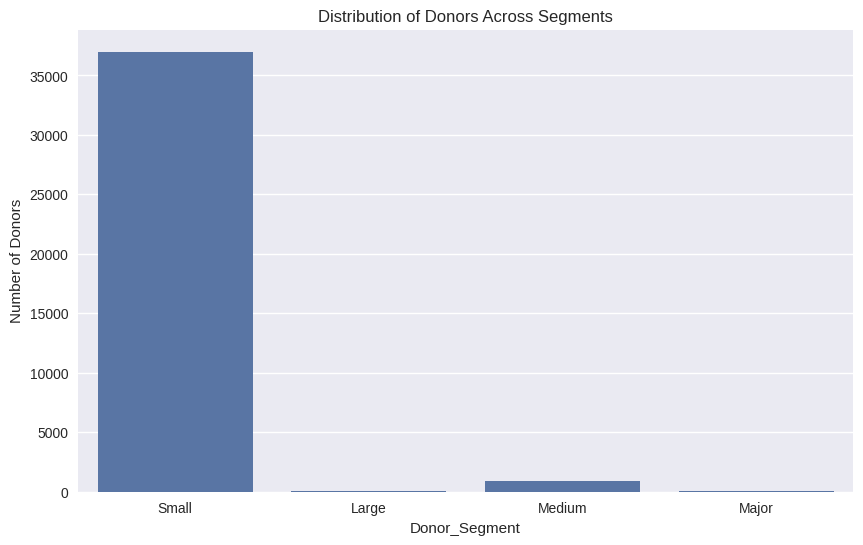

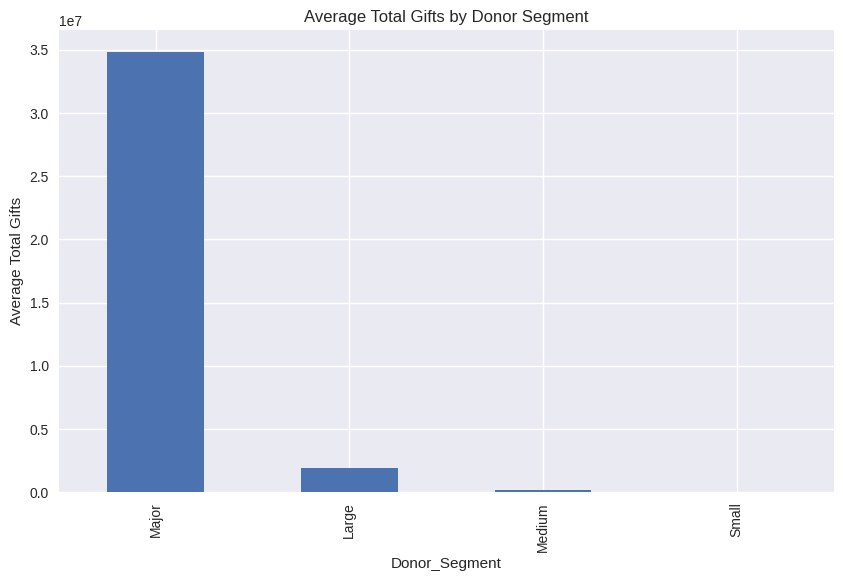

              Unique donor ID   Total Gifts avg_annual_donation            
                        count           sum                mean      median
Donor_Segment                                                              
Large                      83  1.583282e+08           272509.78   185000.00
Major                      23  8.005029e+08          4972067.91  1914285.71
Medium                    867  1.535644e+08            25303.08    17853.14
Small                   36990  2.027148e+08              782.89      314.29


In [19]:
# Donor Segmentation
def segment_donors(df):
    """
    Segment donors based on their average annual donation amount.
    """
    # Calculate average annual donation
    year_columns = [f'Total donations in {year}' for year in range(2017, 2024)]
    df['avg_annual_donation'] = df[year_columns].mean(axis=1)

    # Define segmentation function
    def assign_segment(amount):
        if amount < 1000:
          return 'Small'
        elif amount <= 10000:
          return 'Medium'
        else:
          return 'Large'

    def four_segment_donation(amount):
        if amount <= 10000:
            return 'Small'
        elif amount <= 100000:
            return 'Medium'
        elif amount <= 1000000:
            return 'Large'
        else:
            return 'Major'

    # Apply segmentation
    # df['Donor_Segment'] = df['avg_annual_donation'].apply(assign_segment)
    df['Donor_Segment'] = df['avg_annual_donation'].apply(four_segment_donation)

    # Visualize segmentation
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Donor_Segment', data=df)
    plt.title('Distribution of Donors Across Segments')
    plt.ylabel('Number of Donors')
    plt.show()

    # Calculate average total gifts by segment
    segment_avg_gifts = df.groupby('Donor_Segment')['Total Gifts'].mean().sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    segment_avg_gifts.plot(kind='bar')
    plt.title('Average Total Gifts by Donor Segment')
    plt.ylabel('Average Total Gifts')
    plt.show()

    return df

# Apply segmentation
df = segment_donors(df)

# Display segment statistics
print(df.groupby('Donor_Segment').agg({
    'Unique donor ID': 'count',
    'Total Gifts': 'sum',
    'avg_annual_donation': ['mean', 'median']
}).round(2))

## Temporal Analysis of Donations

The temporal analysis examines annual and monthly donation patterns:

Annual trends:
- Overall growth in total donations from 2017 to 2023
- Significant spike in donations during 2020-2021, possibly due to pandemic-related giving

Monthly distribution:
- Strong seasonality in donations, with December showing the highest contribution
- Secondary peaks in February and May

These patterns suggest opportunities for targeted campaign timing and the potential need for strategies to smooth out donation inflows throughout the year.

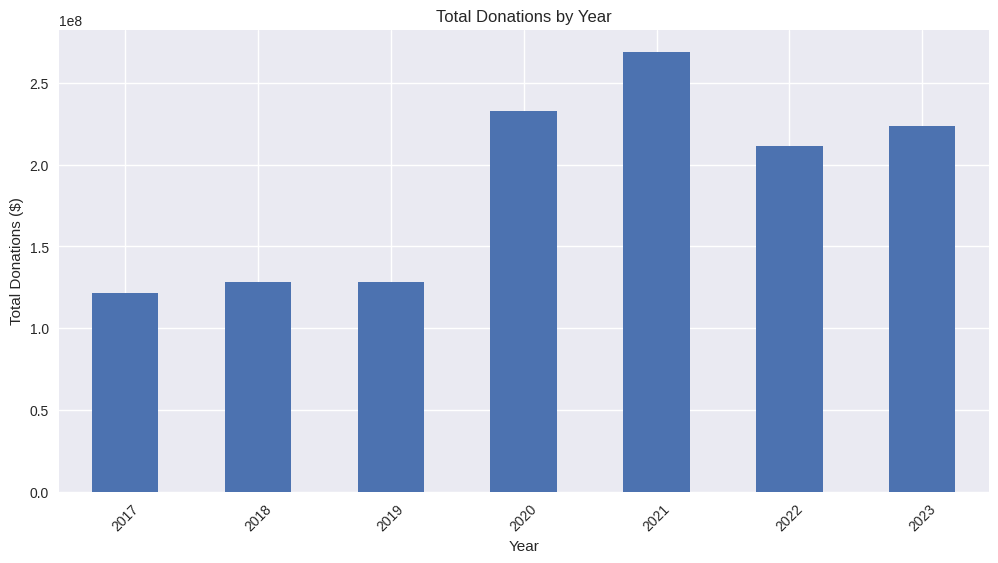

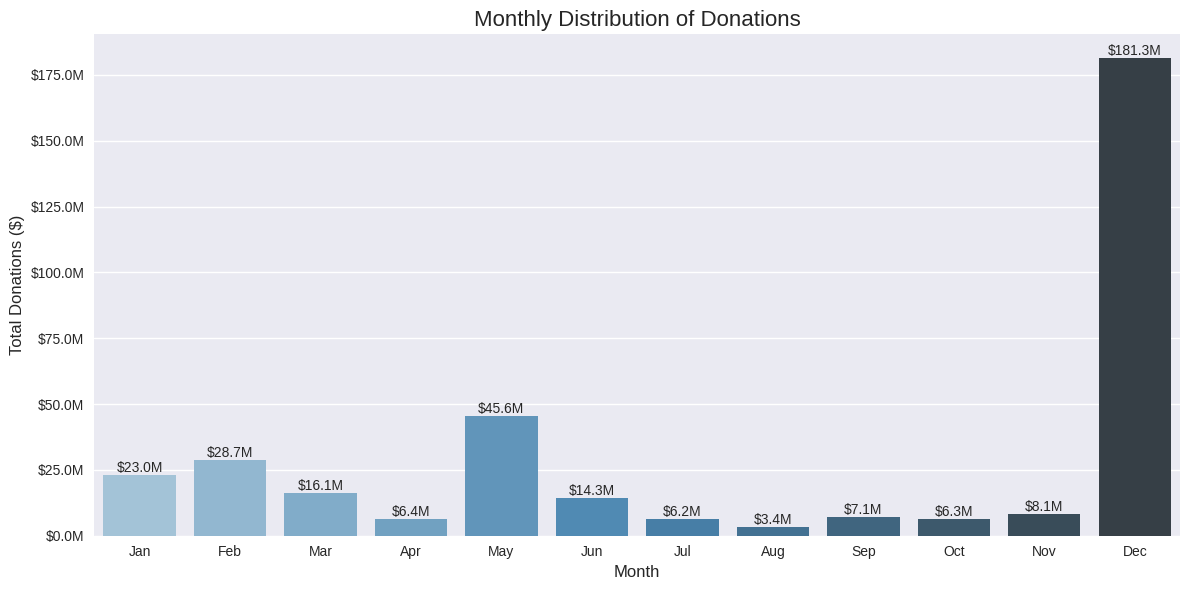

Annual Donation Summary:
Total donations in 2017    1.213753e+08
Total donations in 2018    1.281015e+08
Total donations in 2019    1.280453e+08
Total donations in 2020    2.329840e+08
Total donations in 2021    2.691346e+08
Total donations in 2022    2.116012e+08
Total donations in 2023    2.238685e+08
dtype: float64

Monthly Donation Summary:
Month
1     2.299128e+07
2     2.867890e+07
3     1.605647e+07
4     6.389319e+06
5     4.564942e+07
6     1.428384e+07
7     6.201826e+06
8     3.402199e+06
9     7.116131e+06
10    6.255506e+06
11    8.127950e+06
12    1.813214e+08
Name: Amount of last donation, dtype: float64


In [20]:
# Temporal Analysis of Donations

# Annual donation trends
annual_donations = df[[f'Total donations in {year}' for year in range(2017, 2024)]].sum()

plt.figure(figsize=(12, 6))
annual_donations.plot(kind='bar')
plt.title('Total Donations by Year')
plt.xlabel('Year')
plt.ylabel('Total Donations ($)')
plt.xticks(range(7), range(2017, 2024), rotation=45)
plt.show()

# Calculate total donations by month
df['Month'] = pd.to_datetime(df['Date of last donation']).dt.month
monthly_donations = df.groupby('Month')['Amount of last donation'].sum()

# Create the bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=monthly_donations.index, y=monthly_donations.values, palette='Blues_d')

# Customize the chart
plt.title('Monthly Distribution of Donations', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Donations ($)', fontsize=12)
plt.xticks(range(12), calendar.month_abbr[1:], rotation=0)

# Format y-axis to display in millions
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

# Add value labels on top of each bar
for i, v in enumerate(monthly_donations.values):
    ax.text(i, v, f'${v/1e6:.1f}M', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Annual Donation Summary:")
print(annual_donations)
print("\nMonthly Donation Summary:")
print(monthly_donations)

## Donor Retention Analysis

Donor retention is analyzed across different segments over time:
- Medium donors show the highest average retention rate (84.26%)
- Small donors have the lowest average retention rate (68.84%)
- Large and Major donors show similar retention rates (around 81%)
- Retention rates for all segments show some volatility year-over-year

Donor retention is then analyzed across different segments over time using a Kaplan-Meier estimate:
- Small donors show the lowest retention rate, with a steep decline over time; After 7 years, Small donors have only about 35% retention probability
- Medium donors have the highest retention rate, followed closely by Large donors; Medium and Large donors maintain around 75-80% retention probability even after 7 years
- Major donors start with high retention but show a gradual decline over time; Major donors show interesting behavior, with initial high retention but a gradual decline to about 65% by year 7

These findings highlight:
- The need for targeted retention strategies for Small donors
- The importance of maintaining strong relationships with Medium and Large donors, who show the most loyalty
- Potential areas for investigation into why Major donors show declining retention over time
- Opportunities for segment-specific engagement strategies to improve long-term retention across all groups

The Kaplan-Meier estimate provides a more nuanced view of retention over time compared to simple year-over-year rates, allowing for better long-term planning and resource allocation in donor relationship management.

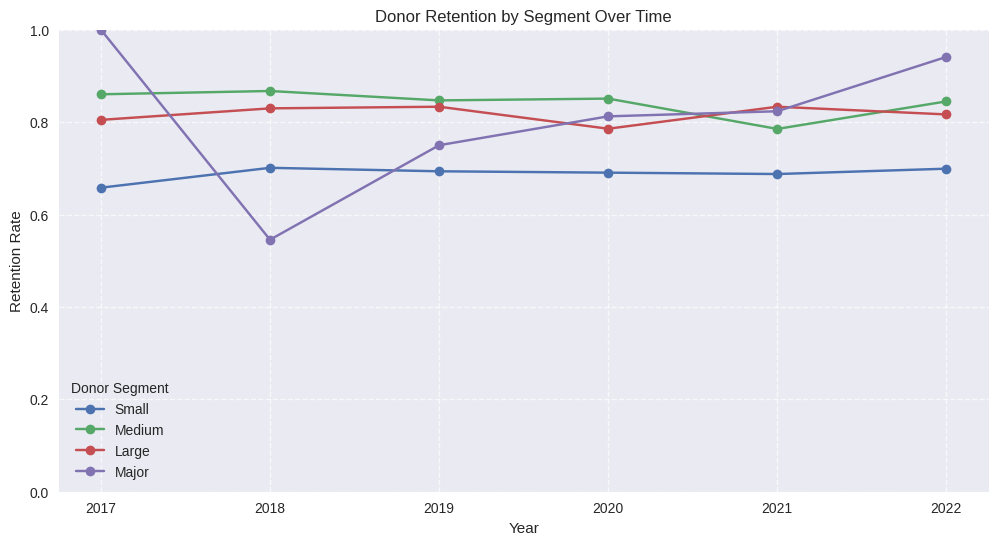

Average Retention Rates by Segment:
Small: 68.84%
Medium: 84.26%
Large: 81.73%
Major: 81.21%


In [21]:
# Donor Retention Analysis

def calculate_retention_rate(df, year, segment):
    current_year_donors = df[(df[f'Total donations in {year}'] > 0) & (df['Donor_Segment'] == segment)]['Unique donor ID']
    next_year_donors = df[df[f'Total donations in {year+1}'] > 0]['Unique donor ID']
    retained_donors = current_year_donors[current_year_donors.isin(next_year_donors)]
    return len(retained_donors) / len(current_year_donors) if len(current_year_donors) > 0 else 0

years = range(2017, 2023)
segments = ['Small', 'Medium', 'Large', 'Major']

retention_rates = {segment: [calculate_retention_rate(df, year, segment) for year in years] for segment in segments}

plt.figure(figsize=(12, 6))
for segment in segments:
    plt.plot(years, retention_rates[segment], marker='o', label=segment)

plt.title('Donor Retention by Segment Over Time')
plt.xlabel('Year')
plt.ylabel('Retention Rate')
plt.legend(title='Donor Segment')
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Print average retention rates
print("Average Retention Rates by Segment:")
for segment in segments:
    avg_rate = np.mean(retention_rates[segment])
    print(f"{segment}: {avg_rate:.2%}")

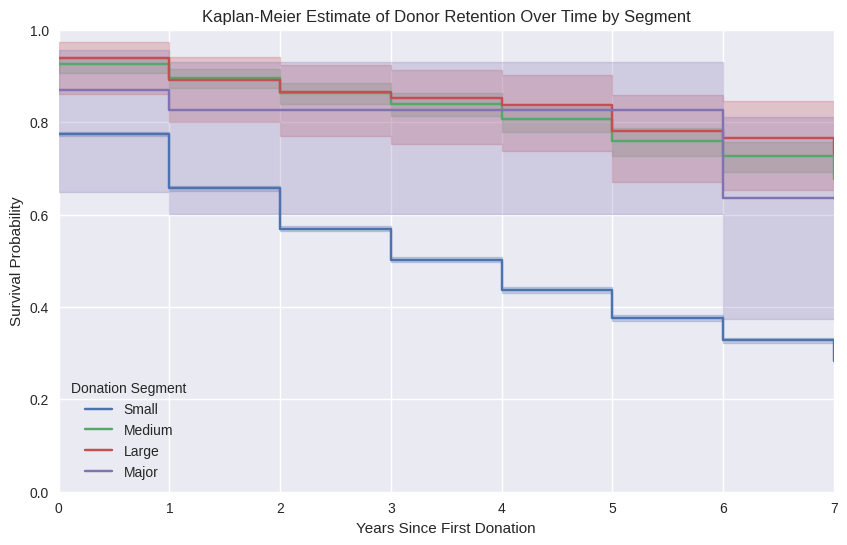

In [22]:
# Kaplan Meier Survival Analysis

# Define the function to determine if a donor has churned based on the date of the last donation
def has_churned(row, current_date):
    last_donation_date = pd.to_datetime(row['Date of last donation'])
    if last_donation_date < current_date - timedelta(days=365):
        return True
    else:
        return False

# Current date for the purpose of checking
current_date = pd.to_datetime(df['Date of last donation']).max()

# Apply the function to determine if the event was observed (churned)
df['event_observed'] = df.apply(
    lambda row: has_churned(row, current_date),
    axis=1
)

# Re-calculate duration
df['duration'] = pd.to_datetime(df['Date of last donation']).dt.year - pd.to_datetime(df['Date of first donation']).dt.year

kmf = KaplanMeierFitter()

segments = ['Small', 'Medium', 'Large','Major']
plt.figure(figsize=(10, 6))

km_segment_survival_probabilities = {}

for segment in segments:
    segment_data = df[df['Donor_Segment'] == segment]
    if not segment_data.empty:
        kmf.fit(durations=segment_data['duration'], event_observed=segment_data['event_observed'], label=segment)
        kmf.plot_survival_function(ci_show=True)
        survival_probabilities = kmf.survival_function_.values.flatten()
        km_segment_survival_probabilities[segment] = survival_probabilities

plt.title('Kaplan-Meier Estimate of Donor Retention Over Time by Segment')
plt.xlabel('Years Since First Donation')
plt.ylabel('Survival Probability')
plt.legend(title='Donation Segment')
plt.xlim(0, 7)  # Adjust the x-axis to a meaningful range
plt.ylim(0, 1.0)  # Ensure y-axis ranges from 0 to 1

plt.show()

## Geographical Analysis

The geographical analysis examines donation patterns by country and U.S. state:

Country-level insights:
- United States dominates total donations
- Significant potential for growth in international markets

U.S. state-level insights:
- New York, California, and New Jersey are the top contributing states
- Opportunities for expansion in other high-income states

This analysis provides direction for geographically targeted fundraising efforts and international expansion strategies.

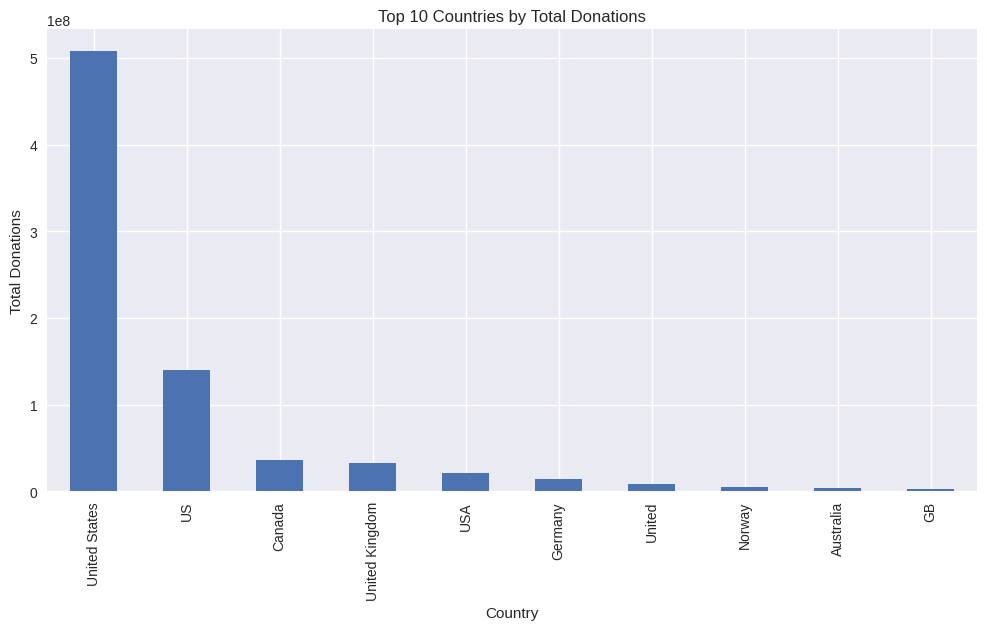

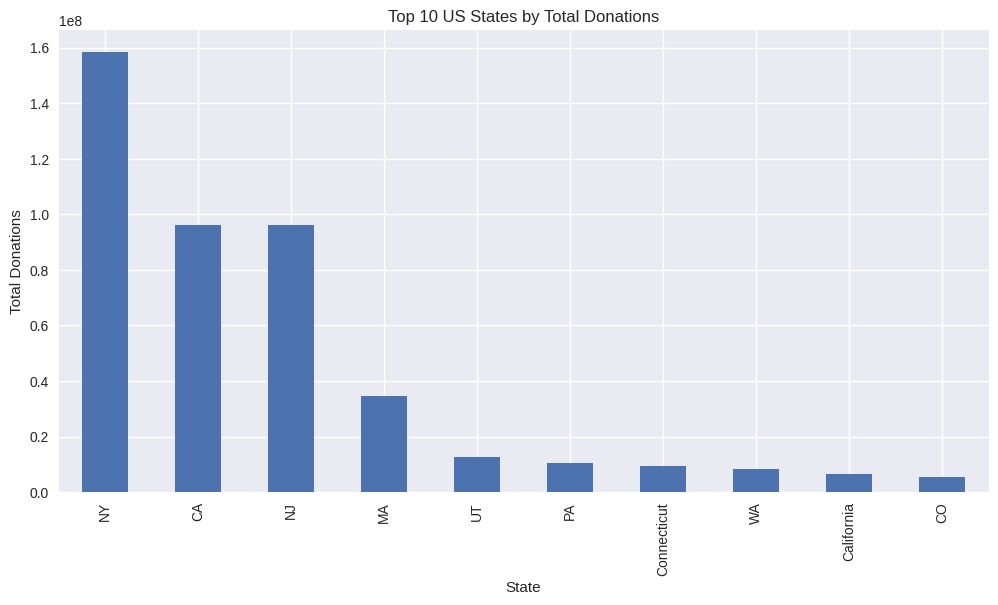

In [23]:
# Geographic Analysis

def analyze_geographic_patterns(df):
    country_donations = df.groupby('Country')['Total Gifts'].sum().sort_values(ascending=False).head(10)

    plt.figure(figsize=(12, 6))
    country_donations.plot(kind='bar')
    plt.title('Top 10 Countries by Total Donations')
    plt.xlabel('Country')
    plt.ylabel('Total Donations')
    plt.show()

    # US State analysis
    us_data = df[df['Country'] == 'United States']
    state_donations = us_data.groupby('State/Province')['Total Gifts'].sum().sort_values(ascending=False).head(10)

    plt.figure(figsize=(12, 6))
    state_donations.plot(kind='bar')
    plt.title('Top 10 US States by Total Donations')
    plt.xlabel('State')
    plt.ylabel('Total Donations')
    plt.show()

analyze_geographic_patterns(df)

## Lead Source Analysis

The lead source analysis compares total donations and donor counts across different acquisition channels:

Key findings:
- Effective Altruism is the top lead source in terms of both total donations and donor count
- Friend/family referrals and proactive research are significant sources of donations
- Some lead sources show high total donations but lower donor counts, indicating high-value donors

These insights can inform marketing strategies, resource allocation for donor acquisition, and tailored approaches for different lead sources.

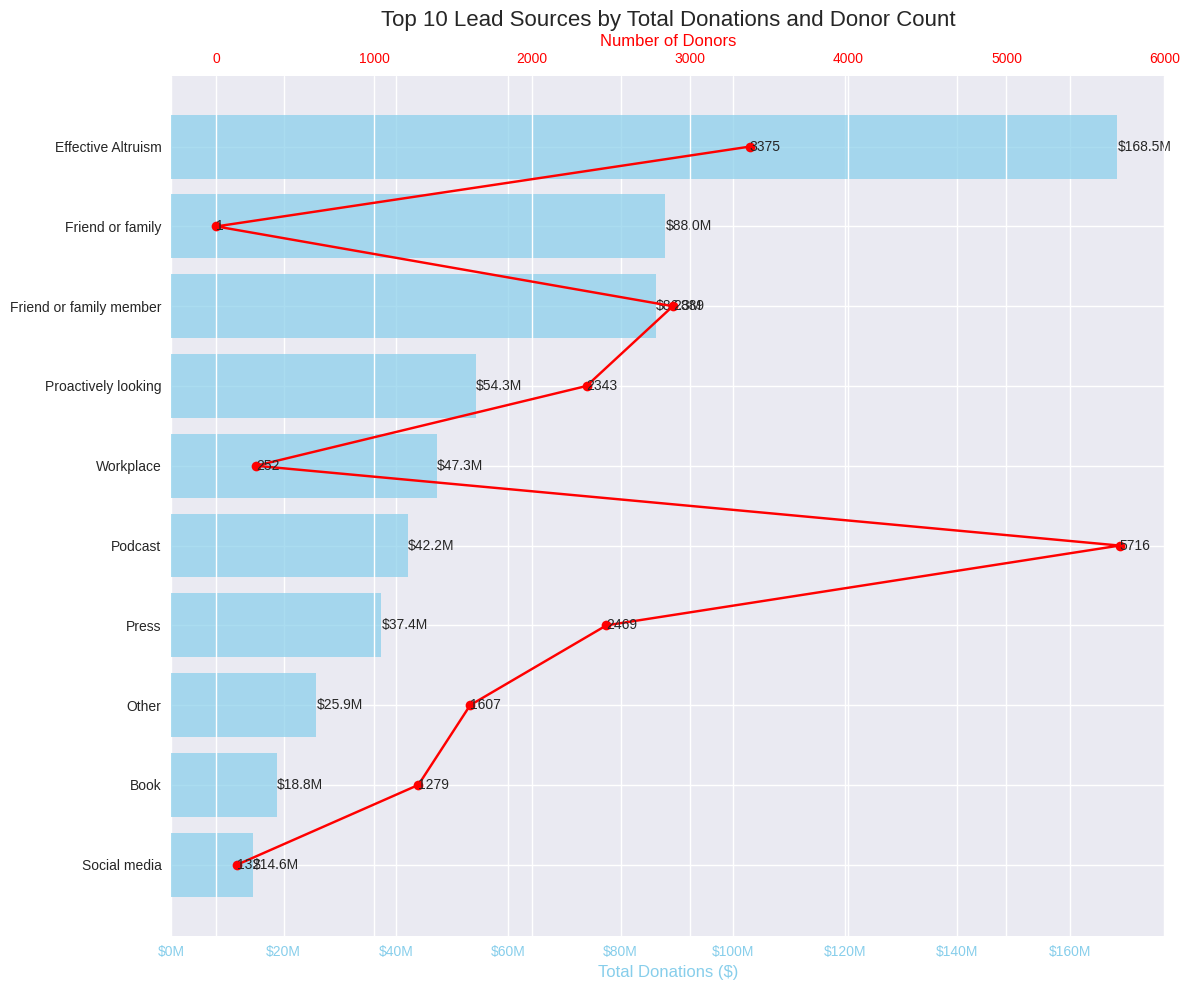

In [24]:
# Lead Source Analysis

# Prepare data
lead_source_data = df.groupby('Lead source').agg({
    'Total Gifts': 'sum',
    'Unique donor ID': 'count'
}).sort_values('Total Gifts', ascending=True).tail(10)  # Changed to ascending=True and tail(10)

# Create horizontal bar chart
fig, ax1 = plt.subplots(figsize=(12, 10))  # Adjusted figure size

# Total donations bars
bars = ax1.barh(lead_source_data.index, lead_source_data['Total Gifts'], color='skyblue', alpha=0.7)
ax1.set_xlabel('Total Donations ($)', color='skyblue', fontsize=12)
ax1.tick_params(axis='x', labelcolor='skyblue')
# Format x-axis to display in millions
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.0f}M'))

# Donor count points
ax2 = ax1.twiny()
ax2.plot(lead_source_data['Unique donor ID'], lead_source_data.index, color='red', marker='o')
ax2.set_xlabel('Number of Donors', color='red', fontsize=12)
ax2.tick_params(axis='x', labelcolor='red')

plt.title('Top 10 Lead Sources by Total Donations and Donor Count', fontsize=16)

# Add value labels to the bars
for i, v in enumerate(lead_source_data['Total Gifts']):
    ax1.text(v, i, f'${v/1e6:.1f}M', va='center', fontsize=10)

# Add donor count labels
for i, v in enumerate(lead_source_data['Unique donor ID']):
    ax2.text(v, i, str(v), va='center', ha='left', fontsize=10)

# Adjust layout
plt.tight_layout()

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

plt.show()

## Job Sector Analysis
The job sector distribution of large and major donors provides insights into the professional backgrounds of the organization's most significant contributors:

Key observations:
- Software and Finance dominate as the top job sectors for large and major donors
- There's a significant presence of retired individuals among top donors
- Academia and Technology sectors also contribute notably
- Other business and Non-profit sectors have a smaller but notable presence

Implications:
1. Targeted outreach strategies could be developed for the software and finance industries
2. Potential for specialized engagement programs for retired high-net-worth individuals e.g. family offices
3. Opportunities to strengthen relationships with academic institutions and non-profits especially for their large, influential networks
4. Possible untapped potential in other business sectors and even within the non-profit world

This analysis helps in tailoring communication, events, and fundraising approaches to resonate with the professional backgrounds of the most impactful donors, potentially leading to more effective high-value donor acquisition and retention strategies.

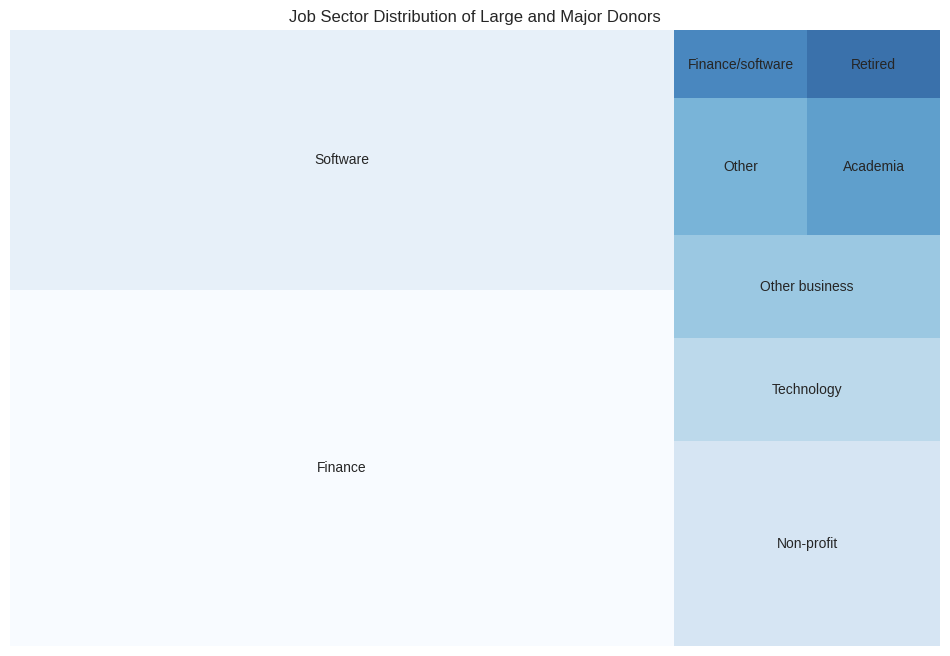

In [25]:
# Job sector analysis

large_major_donors = df[df['Donor_Segment'].isin(['Large', 'Major'])]
job_sector_counts = large_major_donors['Job sector'].value_counts()

# Generate blue colors
norm = plt.Normalize(vmin=0, vmax=len(job_sector_counts))
colors = [plt.cm.Blues(norm(i)) for i in range(len(job_sector_counts))]

# Plotting
plt.figure(figsize=(12, 8))
squarify.plot(sizes=job_sector_counts.values, label=job_sector_counts.index, alpha=0.8, color=colors)
plt.title('Job Sector Distribution of Large and Major Donors')
plt.axis('off')
plt.show()

## Conclusion

This exploratory data analysis provides valuable insights into donor behavior, segmentation, and giving patterns for the nonprofit organization. Key actionable findings include:

1. Opportunity for targeted retention strategies, especially for small donors, given their steep decline in retention over time
2. Potential for international expansion and growth in underrepresented U.S. states
3. Seasonality in donations, suggesting the need for year-round engagement strategies
4. Importance of cultivating and maintaining relationships with medium to major donors, who show higher long-term retention rates
5. Effectiveness of certain lead sources, particularly Effective Altruism and personal referrals
6. Dominance of software and finance sectors among large and major donors, indicating potential for industry-specific outreach

Additional insights:
- The need for specialized engagement programs for retired high-net-worth individuals
- Opportunities to strengthen relationships with academic institutions and tech companies
- Potential for developing segment-specific retention strategies based on the Kaplan-Meier retention analysis

These insights can inform data-driven decision-making in:
- Tailoring fundraising strategies to specific donor segments and job sectors
- Developing targeted donor engagement and retention programs
- Allocating resources for donor acquisition and relationship management
- Creating industry-specific outreach and communication strategies

Future analyses could explore:
- Predictive modeling for donor behavior and churn risk
- More granular segmentation based on additional attributes
- Correlation between job sectors and donation patterns over time
- Impact of specific engagement strategies on retention rates across segments